<a href="https://colab.research.google.com/github/kithmiGunawardna/Heate_index_model_creation/blob/master/colombo_Tempreture_2012_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install paho-mqtt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.0 MB/s eta 0:00:00


In [ ]:
#imprt libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#to cnecct google drive
from google.colab import drive
import seaborn as sns
import matplotlib as mpl

#chec stationarity
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline

#differncing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import the seasonal_decompose function from the statsmodels module
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

#detranding
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

#building Arema Model
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


#to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import pickle
from google.colab import files
from statsmodels.tsa.stattools import acf

import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet


In [ ]:
#import dataset
drive.mount('/content/drive')
df_t_row= pd.read_csv('/content/drive/My Drive/IOTB/colombo_t_2012-2018.csv')
df_rh_row = pd.read_csv('/content/drive/My Drive/IOTB/colombo_rh_2012-2018.csv')


In [ ]:
df_t_row

In [ ]:
df_rh_row

**get the idea about humidity data set**

In [ ]:
# Find duplicate rows (default is 'first' to mark all but the first occurrence as duplicates)
duplicates = df_rh_row.duplicated()

print("Boolean series indicating duplicate rows:")
print(duplicates)

# Output DataFrame rows that are duplicates
print("\nRows that are duplicates:")
print(df_rh_row[duplicates])

In [ ]:
print (df_rh_row['station_id'].unique())
print (df_rh_row['station_name'].unique())
print (df_rh_row['element_name'].unique())
print (df_rh_row['year'].unique())

In [ ]:
# Check for missing values
print(df_rh_row.isnull().sum())

**cleaning the humidity dataset**

In [ ]:
#function for clean the data set
def cleaning_dataset(df):
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.drop(df[df['element_name'] == 'RHMIN'].index)
    df = df.drop(df[(df['month'] == 2) & (df['day'].isin([29,30,31]))& (df_t_row['obs_val'].isnull())].index)
    df = df.drop(df[(df['month'].isin([4,6,9,11]) & (df['day'] == 31))].index)

    return df

In [ ]:
df_rh= cleaning_dataset(df_rh_row)

In [ ]:
df_rh

**get the idea about temreture data set**

In [ ]:
# Find duplicate rows (default is 'first' to mark all but the first occurrence as duplicates)
duplicates = df_t_row.duplicated()

print("Boolean series indicating duplicate rows:")
print(duplicates)

# Output DataFrame rows that are duplicates
print("\nRows that are duplicates:")
print(df_t_row[duplicates])

In [ ]:
print (df_t_row['station_id'].unique())
print (df_t_row['station_name'].unique())
print (df_t_row['element_name'].unique())
print (df_t_row['year'].unique())

In [ ]:
# Check for missing values
print(df_t_row.isnull().sum())

*when go through the data set I  get that 3 of this missingg value is geting from feburary 1,2,3 so I decide to fill thoes value*

*to do that I drow histrogram to get idea how the data is spred in that month and decide what methoed should i use*

In [ ]:
feb_2015_data = df_t_row[(df_t_row['year'] == 2015) & (df_t_row['month'] == 2)]

sns.histplot(feb_2015_data['obs_val'], bins=5, kde=True, edgecolor='black')
plt.title('Histogram for February 2015 (Seaborn)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

**data preprocessing for tempruture**

In [ ]:
#get the meadian value
median_value = feb_2015_data['obs_val'].median()

# Condition for filling only null values in February 2015
condition = (df_t_row['month'] == 2) & (df_t_row['year'] == 2015) & (df_t_row['day'].isin([1,2,3])) & (df_t_row['obs_val'].isnull())

df_t_row.loc[condition, 'obs_val'] = median_value

print(df_t_row.isnull().sum())

In [ ]:
df_t_row

In [ ]:
#function for clean the data set
def cleaning_tempreture_dataset(df):
    df = df.dropna()
    df = df.drop(df[df['element_name'] == 'TMPMIN'].index)
    df = df.drop(df[(df['month'] == 2) & (df['day'].isin([29,30,31]))& (df_t_row['obs_val'].isnull())].index)
    df = df.drop(df[(df['month'].isin([4,6,9,11]) & (df['day'] == 31))].index)

    return df

In [ ]:
df_t= cleaning_tempreture_dataset(df_t_row)

In [ ]:
df_t

**check the data in the data set is in actual time**

In [ ]:
row_count_per_year_t = df_rh.groupby('year').size()
row_count_per_year_rh = df_t.groupby('year').size()

print(row_count_per_year_t)
print(row_count_per_year_rh)


**concatanate the data set**


In [ ]:
#rename the column
df_t.rename(columns={'obs_val': 't_val'}, inplace=True)
df_rh.rename(columns={'obs_val': 'rh_val'}, inplace=True)

#remove elements
df_t.drop('element_name', axis=1, inplace=True)
df_rh.drop('element_name', axis=1, inplace=True)

#create index column
df_t['index_column'] = range(1, len(df_t) + 1)
df_rh['index_column'] = range(1, len(df_rh) + 1)

In [ ]:
df_t

In [ ]:
df_rh

In [ ]:
# Set 'station_id' as the index for both DataFrames
df_t.set_index('station_id', inplace=True)
df_rh.set_index('station_id', inplace=True)

#Concatenate along axis 1
df = pd.concat([df_t, df_rh],axis=1)

df.reset_index(inplace=True)
df = df.loc[:, ~df.columns.duplicated()]

In [ ]:
df

**Create heat index**

In [ ]:
def calculate_heat_index(T, RH):
    HI = -42.379 + 2.04901523 * T + 10.14333127 * RH - 0.22475541 * T * RH \
         - 0.00683783 * T * T - 0.05481717 * RH * RH + 0.00122874 * T * T * RH \
         + 0.00085282 * T * RH * RH - 0.00000199 * T * T * RH * RH
    return HI

In [ ]:
# Apply the formula to the dataset
df['heat_index'] = df.apply(lambda row: calculate_heat_index(row['t_val'], row['rh_val']), axis=1)

In [ ]:
df

**convet dataframe to monthly base dataframe**

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [ ]:
df

In [ ]:
df.dtypes

In [ ]:
# Group by month
df['month'] = df['date'].dt.to_period('M')

In [ ]:
df['month']

In [ ]:
df

In [ ]:
average_by_month = df.groupby('month')['heat_index'].mean().reset_index()



In [ ]:
 df_heat_index= average_by_month

In [ ]:
df_heat_index.dtypes

In [ ]:
# 2. Convert the 'month' column to a string or datetime format
df_heat_index['month'] = df_heat_index['month'].astype(str)

# 3. Convert the 'month' column to datetime format
df_heat_index['month'] = pd.to_datetime(df_heat_index['month'], format='%Y-%m')



In [ ]:
df_heat_index

**Time serise model building**

**Visualization**

In [ ]:
# Create the plot
# Create the plot
plt.plot(df_heat_index['month'], df_heat_index['heat_index'], linestyle = 'dotted')

# Add title and axis labels
plt.title('Heat Index')
plt.xlabel('year')
plt.ylabel('heat index')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
# Boxplot

sns.boxplot(x = df_heat_index['heat_index'])
plt.title('Boxplot of Average heat index by Month')
plt.xlabel('heat index')

plt.show()

In [ ]:
def plot_df(df, x, y, title="", xlabel='month', ylabel='Heat index', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df_heat_index,x=df_heat_index['month'] ,y= df_heat_index['heat_index'], title='Heat Index')

In [ ]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df_heat_index['heat_index'], model='multiplicative', period= 12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_heat_index['heat_index'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

*so there is no outlairs*

**Stationary checking**

In [ ]:
#first methoed


#ADF test
# ADF Test
result = adfuller(df_heat_index['heat_index'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
print (result)

*in here p value is 0.2993 and significant value at 0.05 is - 2.903 so p value is higher and ADF value is higher than all critical value so this is non stationary*

In [ ]:
def kpss_test(data, **kw):
    statistic, p_value, n_lags, critical_values = kpss(data, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df_heat_index['heat_index'])

**Detranding**

*ADS give that data set is not stationary and KPSS gives that the dataset is stationay. In such a case we can do detranding and make the data set sationary.This kind of situation said that dataset has trend*

In [ ]:
# #this using substracting by the least squares
# detrended = signal.detrend(df_heat_index2['heat_index'].values)
# plt.plot(detrended)
# plt.title('Heat Index detrended by subtracting the least squares fit', fontsize=16)

In [ ]:
# # Using statmodels: Subtracting the Trend Component
# result_mul = seasonal_decompose(df_heat_index1['heat_index'], model='multiplicative', period=12)
# detrended1 = df_heat_index1['heat_index'].values - result_mul.trend
# plt.plot(detrended1)
# plt.title('Heat Index detrended by subtracting the trend component', fontsize=10)

In [ ]:
# # Convert NaN and infinite values to NaN
# detrended1 = np.where(np.isfinite(detrended1), detrended1, np.nan)

# # Drop NaN values
# detrended_clean = detrended1[~np.isnan(detrended1)]

**Didderence**

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_heat_index.heat_index); axes[0, 0].set_title('Original Series')
plot_acf(df_heat_index.heat_index, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_heat_index.heat_index.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_heat_index.heat_index.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_heat_index.heat_index.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_heat_index.heat_index.diff().diff().dropna(), ax=axes[2, 1])



plt.tight_layout()
plt.show() # Display the plots


In [ ]:
differncing_heat_index =df_heat_index.heat_index.diff().copy()
# Convert NaN and infinite values to NaN
differncing_heat_index = np.where(np.isfinite(differncing_heat_index), differncing_heat_index, np.nan)

# Drop NaN values
differncing_heat_index_clean = differncing_heat_index[~np.isnan(differncing_heat_index)]

In [ ]:
differncing_heat_index

In [ ]:
adf_result = adfuller(differncing_heat_index_clean, autolag='AIC')

# Displaying results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

**Build the dataset**

In [ ]:
# Check that the length matches
assert len(differncing_heat_index) == len(df_heat_index), "Array length doesn't match DataFrame length."

In [ ]:
df_heat_index.heat_index

In [ ]:
# Add the array as a new column
df_heat_index['differnciation_value'] = differncing_heat_index

In [ ]:
df_heat_index

In [ ]:
df_heat_index.dtypes

In [ ]:
df_heat_index = df_heat_index.dropna()

In [ ]:
# Assuming df is your DataFrame
df_heat_index.set_index('month', inplace=True)
df_heat_index.drop(columns=['heat_index'], inplace=True)

In [ ]:
df_heat_index

**Data Spliting**

In [ ]:
#train_data, test_data = df_heat_index.differnciation_value[3:int(len(df_heat_index['differnciation_value'])*0.9)], df_heat_index['differnciation_value'][int(len(df_heat_index['differnciation_value'])*0.9):]
train_data = df_heat_index['differnciation_value'][:-12]
test_data = df_heat_index['differnciation_value'][-12:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_heat_index['differnciation_value'], 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
train_data

In [ ]:
test_data

**AREMA model Building**

In [ ]:
model = pm.auto_arima(train_data,
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=13, max_q=13, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=2,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

# Print model summary
print(model.summary())


In [ ]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
arima_model = ARIMA(train_data, order=model.order)
arima_fit = arima_model.fit()



**prediction for past 12 months**

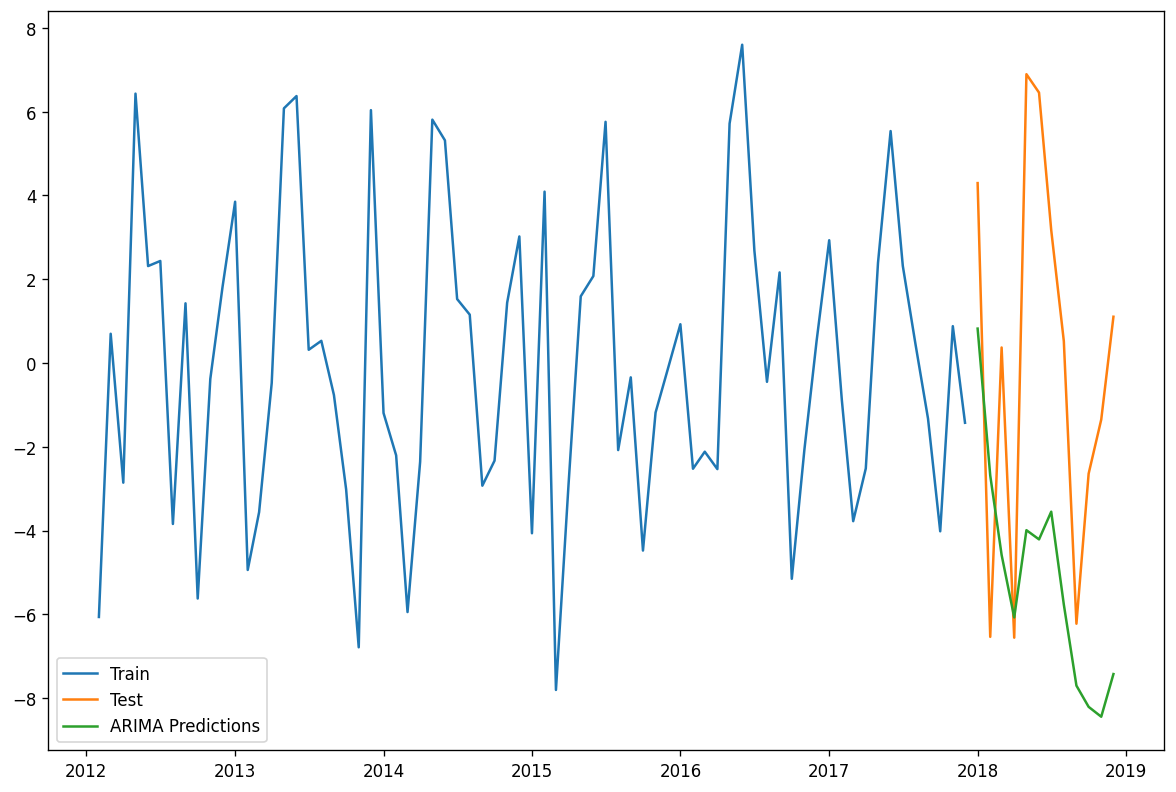

In [ ]:
# #predictions = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

start_prediction = 83-12
end_prediction = 83-1

# Perform prediction
predictions_past_12_months = arima_fit.predict(start=start_prediction, end=end_prediction, typ='levels',alpha=0.05)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_data.index, predictions_past_12_months, label='ARIMA Predictions')
plt.legend()
plt.show()


In [ ]:
predictions_past_12_months

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(predictions_past_12_months-test_data)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_past_12_months.values, test_data.values)


**pickel file for past 12 month**

In [ ]:
pickle_file_name = 'arima_model.pkl'
with open(pickle_file_name, 'wb') as pkl_file:
    pickle.dump(arima_fit, pkl_file)

print(f"Model saved to {pickle_file_name}")

In [ ]:
files.download(pickle_file_name)

In [ ]:
# p = d = q = range(0, 13)
# results = []

# # Generate all different combinations of p, d and q triplets
# pdq = list(itertools.product(p, d, q))

# for param in pdq:
#     try:
#         model = ARIMA(train_data, order=param)
#         model_fit = model.fit()
#         aic = model_fit.aic
#         mse = mean_squared_error(train_data, model_fit.fittedvalues)
#         results.append((param, aic, mse))
#     except:
#         continue

# # Convert to DataFrame
# results_df = pd.DataFrame(results, columns=['parameters', 'aic', 'mse'])
# print(results_df.sort_values(by='aic').head())

**Future 12 months prediction**

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=580.631, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=528.806, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=578.634, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=528.031, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=520.842, Time=0.19 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=508.836, Time=0.26 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=497.936, Time=0.34 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=487.303, Time=0.46 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=482.561, Time=0.33 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=482.445, Time=0.32 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=482.032, Time=0.35 sec
 ARIMA(10,2,0)(0,0,0)[0] intercept   : AIC=483.860, Time=0.38 sec
 ARIMA(9,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.

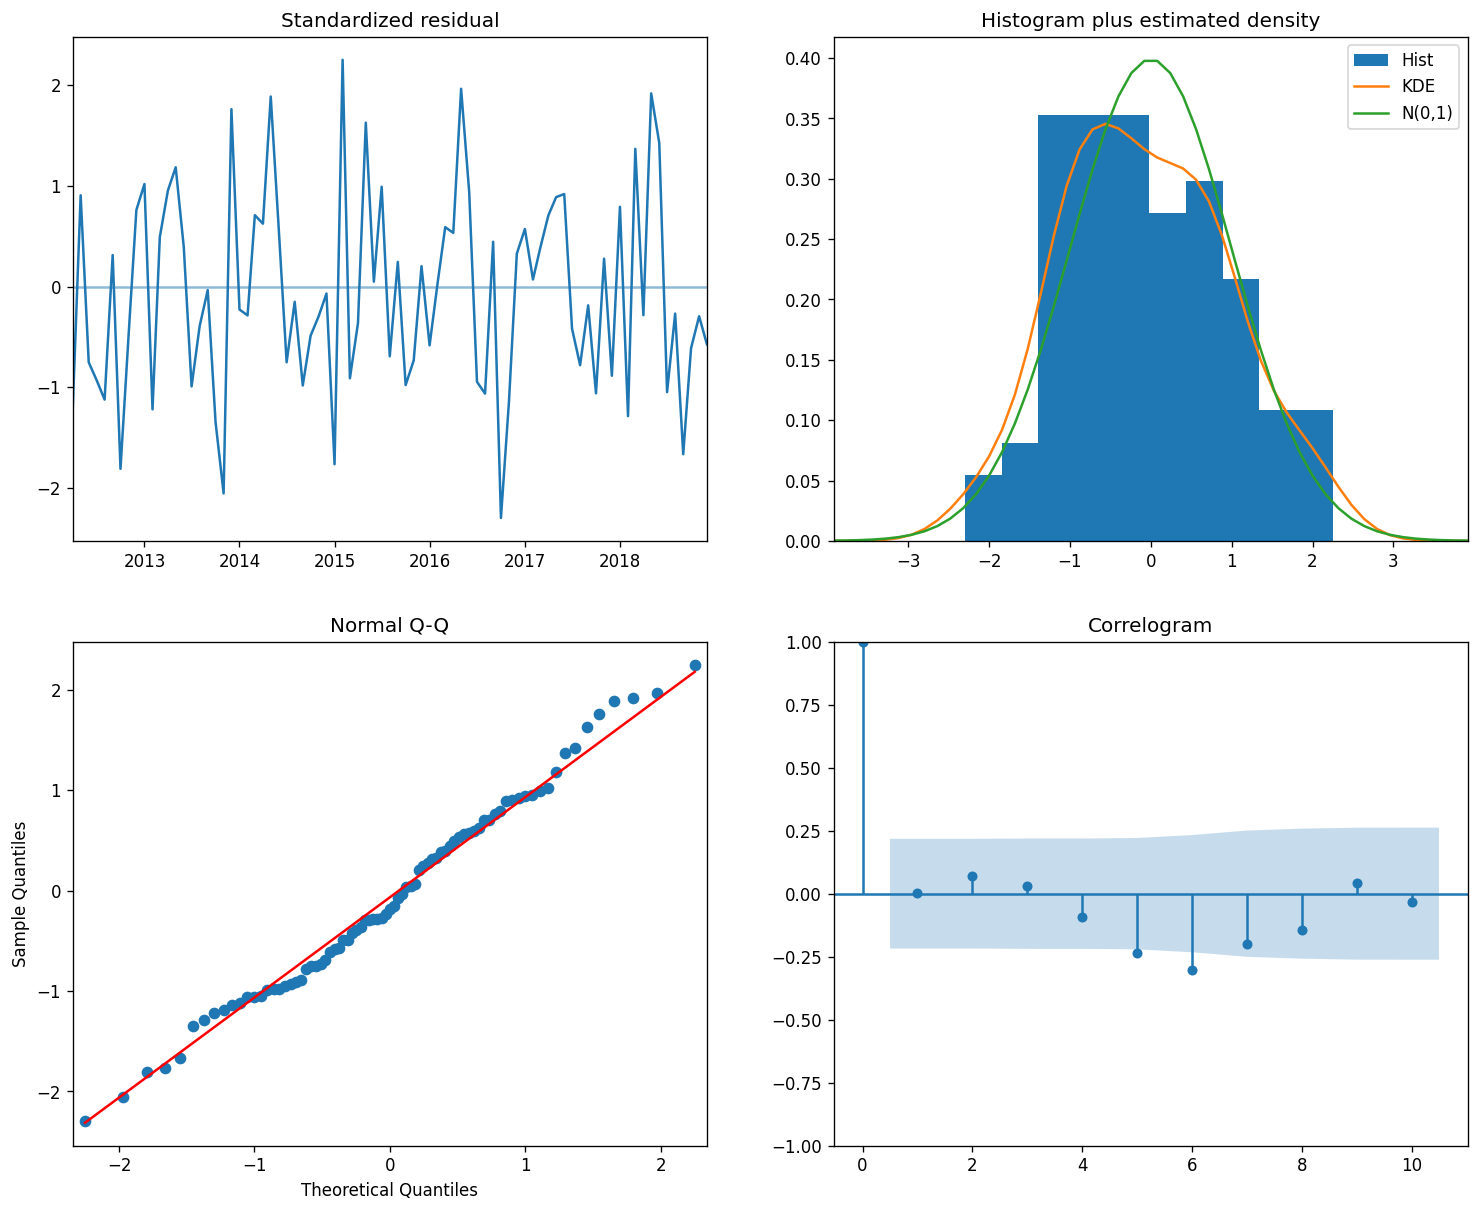

In [ ]:
full_data = pd.concat([train_data, test_data])

Future_model = pm.auto_arima(full_data,
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=13, max_q=13, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=2,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

# Print model summary
print(Future_model.summary())

# Print model summary

Future_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
arima_model_future = ARIMA(full_data, order=Future_model.order)
arima_fit_future = arima_model_future.fit()

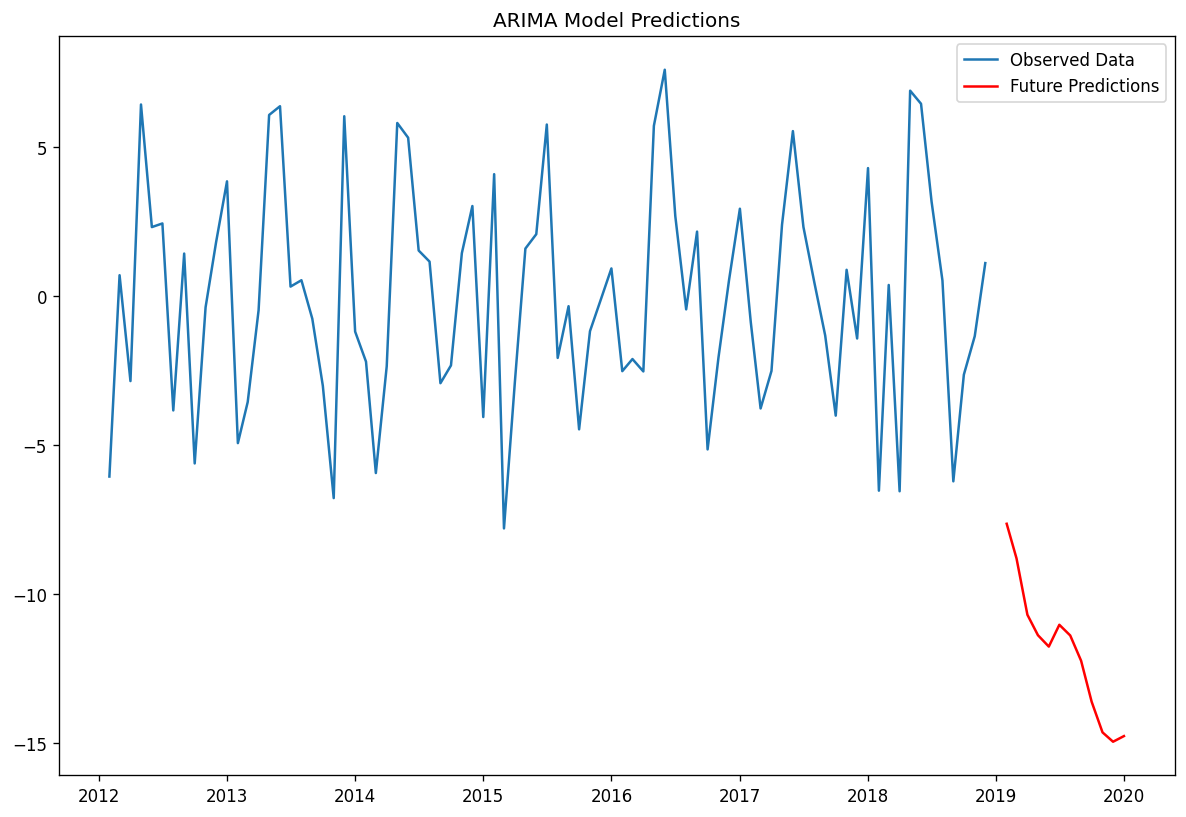

In [ ]:
# #predictions = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

start_prediction = 83
end_prediction = 83 + 11

# Perform prediction
predictions_future_12_months = arima_fit.predict(start=start_prediction, end=end_prediction, typ='levels',alpha=0.05)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(full_data, label='Observed Data')
plt.plot(pd.date_range(start=full_data.index[-1], periods=13, freq='M')[1:], predictions_future_12_months, label='Future Predictions', color='red')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()

In [ ]:
predictions_future_12_months

2019-01-01    -7.648262
2019-02-01    -8.810795
2019-03-01   -10.703649
2019-04-01   -11.390004
2019-05-01   -11.772422
2019-06-01   -11.040222
2019-07-01   -11.399470
2019-08-01   -12.249077
2019-09-01   -13.623942
2019-10-01   -14.653367
2019-11-01   -14.967616
2019-12-01   -14.777757
Freq: MS, Name: predicted_mean, dtype: float64

**pickel file for future prediction**

In [ ]:
pickle_file_name = 'arima_model_future.pkl'
with open(pickle_file_name, 'wb') as pkl_file:
    pickle.dump(arima_fit_future, pkl_file)

print(f"Model saved to {pickle_file_name}")

Model saved to arima_model_future.pkl


In [ ]:
files.download(pickle_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>